<a href="https://colab.research.google.com/github/HuanAII/MODULE-5-classification-/blob/main/Project_Vanishing_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import random
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader , random_split
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

In [14]:
device=torch.device('cuda : 0' if torch.cuda.is_available() else'cpu')

In [8]:
#tao seed
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)#tao cac mang ngau nhien
  torch.manual_seed(seed)#dat seed cho cac phep tinh ngau nhieen nhu khoi tao cho nn.linear
  torch.cuda.manual_seed(seed)#dat seed cho cac phep tinh ngau nhieen tren gpu cua pytorch
  torch.cuda.manual_seed_all(seed)#dat seed cho tat ca cac gpu trong he thong
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark=True
seed =42
set_seed(seed)

In [32]:
batch_size=512
train_dataset=FashionMNIST('./data',train=True, download=True,
                           transform=transforms.ToTensor())
test_dataset=FashionMNIST('./data',train=False, download=True,
                           transform=transforms.ToTensor())

In [33]:
def imshow(img):
    img = img / 2 + 0.5  # Chuyển lại từ tensor [-1,1] sang [0,1]
    npimg = img.numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

# Lấy 4 hình ảnh đầu tiên từ tập huấn luyện
dataiter = iter(torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True))
images, labels = dataiter.next()

# Hiển thị các hình ảnh
imshow(torchvision.utils.make_grid(images))

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [34]:
#Val split and create DataLaaoder
train_ratio=0.9
train_size= int(len(train_dataset)*train_ratio)
val_size=len(train_dataset)-train_size
train_subset,val_subset=random_split(train_dataset,[train_size,val_size])
train_loader=DataLoader(train_subset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)
val_loader=DataLoader(val_subset,batch_size=64,shuffle=False)

In [42]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP , self).__init__()
    self.layer1=nn.Linear(input_dims , hidden_dims)
    self.layer2=nn.Linear(hidden_dims , hidden_dims)
    self.layer3=nn.Linear(hidden_dims , hidden_dims)
    self.layer4=nn.Linear(hidden_dims , hidden_dims)
    self.layer5=nn.Linear(hidden_dims , hidden_dims)
    self.layer6=nn.Linear(hidden_dims , hidden_dims)
    self.layer7=nn.Linear(hidden_dims , hidden_dims)
    self.output=nn.Linear(hidden_dims , output_dims)
    for module in self.modules():
      if isinstance(module , nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=1.0)
        nn.init.constant_(module.bias ,0)
  def forward(self , x):
    x=nn.Flatten()(x)
    x=self.layer1(x)
    x=nn.BatchNorm1d(self.hidden_dims,device=device)(x)
    x=nn.Sigmoid()(x)
    x=self.layer2(x)
    x=nn.BatchNorm1d(self.hidden_dims,device=device)(x)
    x=nn.Sigmoid()(x)
    x=self.layer3(x)
    x=nn.BatchNorm1d(self.hidden_dims,device=device)(x)
    x=nn.Sigmoid()(x)
    x=self.layer4(x)
    x=nn.BatchNorm1d(self.hidden_dims,device=device)(x)
    x=nn.Sigmoid()(x)
    x=nn.BatchNorm1d(self.hidden_dims,device=device)(x)
    x=self.layer5(x)
    x=nn.BatchNorm1d(self.hidden_dims,device=device)(x)
    x=nn.Sigmoid()(x)
    x=self.layer6(x)
    x=nn.BatchNorm1d(self.hidden_dims,device=device)(x)
    x=nn.Sigmoid()(x)
    x=self.layer7(x)
    x=nn.BatchNorm1d(self.hidden_dims,device=device)(x)
    x=nn.Sigmoid()(x)
    output=self.output(x)
    return output




In [36]:
input_dims=784
hidden_dims=128
output_dims=10
lr=0.01
model=MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=lr)

In [37]:
epochs=100
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
for epoch in range(epochs):
  train_loss=0.0
  train_acc=0.0
  count=0
  model.train()
  for X_train, y_train in train_loader:
    X_train,y_train=X_train.to(device),y_train.to(device)
    optimizer.zero_grad()
    outputs=model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()
    train_acc+=(torch.argmax(outputs,1)==y_train).sum().item()
    count+=len(y_train)
  train_loss/=len(train_loader)
  train_loss_list.append(train_loss)
  train_acc/=count
  train_acc_list.append(train_acc)



In [38]:
for epoch in range(epochs):
  val_loss=0.0
  val_acc=0.0
  count=0
  model.eval()
  with torch.no_grad():
    for X_val,y_val in val_loader:
      X_val, y_val =X_val.to(device), y_val.to(device)
      outputs=model(X_val)
      loss=criterion(outputs, y_val )
      val_loss+=loss.item()
      val_acc+=(torch.argmax(outputs, 1)==y_val).sum().item()
      count+=len(y_val)
  val_loss/=len(test_loader)
  val_loss_list.append(val_loss)
  val_acc/=count
  val_acc_list.append(val_acc)

Text(0.5, 1.0, 'Val Acc')

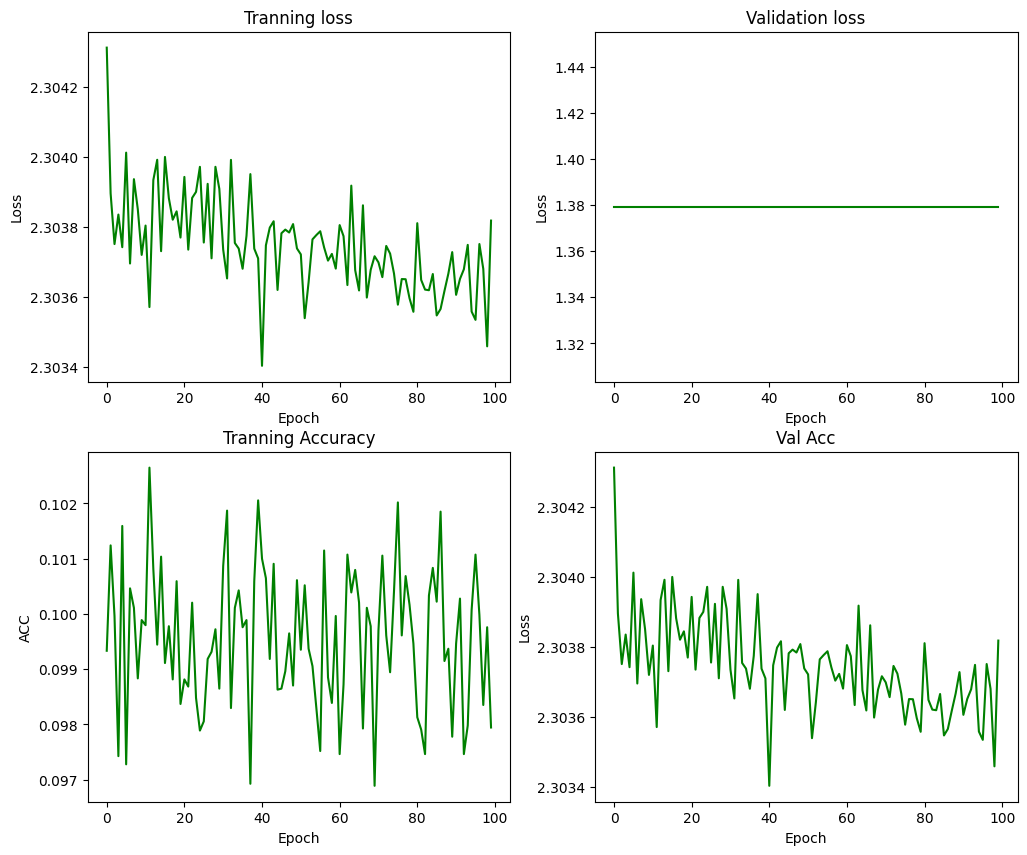

In [40]:
fig,ax=plt.subplots(2,2,figsize=(12,10))
ax[0][0].plot(train_loss_list,color='green')
ax[0][0].set(xlabel='Epoch',ylabel='Loss')
ax[0][0].set_title("Tranning loss")

ax[0][1].plot(val_loss_list,color='green')
ax[0][1].set(xlabel='Epoch',ylabel='Loss')
ax[0][1].set_title("Validation loss")

ax[1][0].plot(train_acc_list,color='green')
ax[1][0].set(xlabel='Epoch',ylabel='ACC')
ax[1][0].set_title("Tranning Accuracy")

ax[1][1].plot(train_loss_list,color='green')
ax[1][1].set(xlabel='Epoch',ylabel='Loss')
ax[1][1].set_title("Val Acc")

In [ ]:
#improve
